<p style="font-family: Arial; font-size:3.5em;color:purple; font-style:bold"><br>
'Kr DST' Study</p><br>

# Reads an analysis DST from FLEX data and plots resolution and others

In [1]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [2]:
# General importings
import os
import sys
import glob
import logging
import math
import numpy  as np
import warnings
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

# Specific IC stuff
import invisible_cities.core.system_of_units  as units

from invisible_cities.io.mcinfo_io import load_mcconfiguration
from invisible_cities.io.mcinfo_io import load_mcparticles_df
from invisible_cities.io.mcinfo_io import load_mchits_df
from invisible_cities.io.mcinfo_io import load_mcsensor_positions
from invisible_cities.io.mcinfo_io import load_mcsensor_response_df
from invisible_cities.io.mcinfo_io import get_sensor_types
from invisible_cities.io.mcinfo_io import get_sensor_binning
from invisible_cities.io.mcinfo_io import get_event_numbers_in_file
from invisible_cities.core.core_functions import in_range


In [9]:
from nextflex.core import Setup

In [3]:
from nextflex.krypton_dst import get_evt_true_positions_and_energy
from nextflex.krypton_dst import NN

In [29]:
from nextflex.krypton_analysis import histo_df
from nextflex.krypton_analysis import histos_df
from nextflex.krypton_analysis import kr_point_resolution
from nextflex.krypton_analysis import kr_point_resolution2
from nextflex.krypton_analysis import q_sipm
from nextflex.krypton_analysis import  q4_sipm

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

## Study of TP response

Common to all configurations:

- 60 PMTs, QE included
- Hamamatsu SiPMs, 1.3 x 1.3 mm2
- TP at 15 mm from anode



In [64]:
FDATA = os.environ['FLEXDATA']
print(f'path to data ={FDATA}')

path to data =/Users/jj/Development/flexdata


In [65]:
ofile_path = f"{FDATA}/kdsts"
print(f"Path to ofile = {ofile_path}")

Path to ofile = /Users/jj/Development/flexdata/kdsts


## FLEX100_M6_O6 configuration

- Assumes masks of 6 cm height and 6 cm hole



### Ideal case: 

- SiPM PDE = 1
- mask PDE = 1 (no teflon membranes)
- qTh      = 0 (no cutoff in SiPMs)

In [66]:
setup = Setup(sipmPDE    = 1.0,
              maskPDE    = 1.0,
              qTh        = 0.0,
              tpConfig   = "FLEX100_M6_O6")

In [67]:
print(f'configuration name = {setup.name}')

configuration name = PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0_FLEX100_M6_O6


In [68]:
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")

 dst name = /Users/jj/Development/flexdata/kdsts/PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0_FLEX100_M6_O6.csv


In [69]:
krdst = pd.read_csv(ofile)

In [70]:
krdst.head()

,Unnamed: 0,event_id,true_x,true_y,true_z,KE,S1e,S2e,Qtot,xMax,...,rPos,qMax,qL,qR,qU,qD,dxPos,dyPos,dxMax,dyMax
0,0,101900,359.476500,9.660492,722.39014,55.389090,18,8395,794,357.65,...,372.041112,54.0,27.0,44.0,18.0,42.0,-0.288295,-2.615824,1.826501,-5.889508
1,1,101901,186.837890,-43.123417,1162.73030,41.543297,22,8774,747,186.60,...,229.763372,38.0,37.0,28.0,35.0,22.0,1.596625,1.398689,0.237891,3.526583
2,2,101902,-259.909730,-53.806812,1087.68680,54.014584,29,8693,829,-264.35,...,311.496957,54.0,23.0,38.0,22.0,41.0,2.412013,-4.631598,4.440271,-7.156812
3,3,101903,-399.442720,-187.637620,699.62256,41.543297,28,7923,756,-404.30,...,586.678595,59.0,15.0,38.0,35.0,27.0,1.663972,-2.065715,4.857281,-1.037619
4,4,101904,77.765274,-40.491470,991.10700,43.017110,35,8940,771,77.75,...,121.386248,50.0,20.0,24.0,43.0,17.0,-0.646428,2.483076,0.015274,6.158530


In [71]:
krdst.columns

Index(['Unnamed: 0', 'event_id', 'true_x', 'true_y', 'true_z', 'KE', 'S1e',
       'S2e', 'Qtot', 'xMax', 'yMax', 'xPos', 'yPos', 'rPos', 'qMax', 'qL',
       'qR', 'qU', 'qD', 'dxPos', 'dyPos', 'dxMax', 'dyMax'],
      dtype='object')

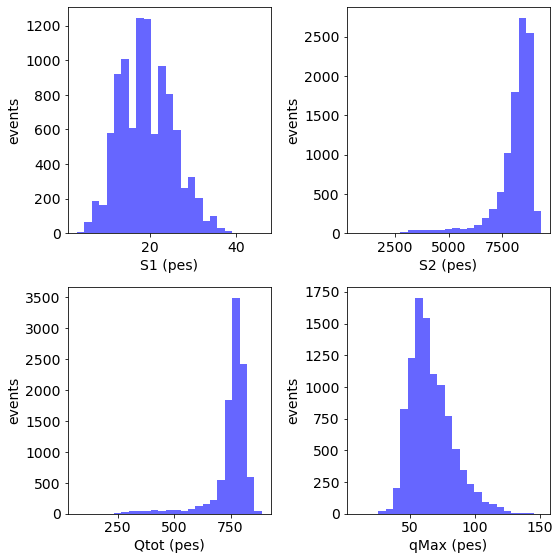

In [72]:
histos_df(krdst, 
          vars    = ('S1e','S2e','Qtot','qMax'), 
          varmins = [0,0,0, 0], 
          varmaxs = [50,10000,1000,200], 
          xlabels = ['S1 (pes)','S2 (pes)','Qtot (pes)','qMax (pes)'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [25],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (8,8))

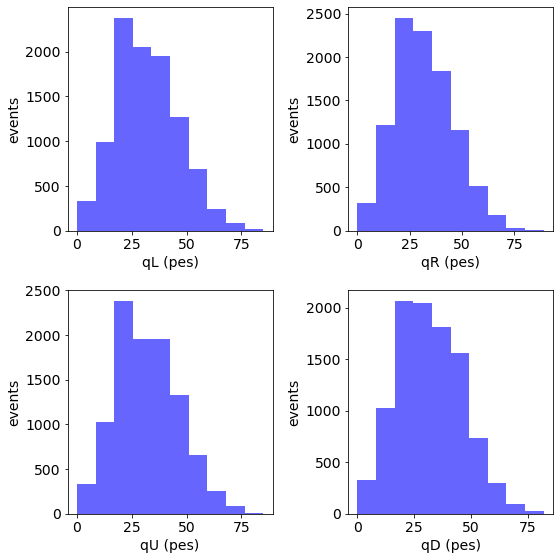

In [73]:
histos_df(krdst, 
          vars    = ('qL','qR','qU','qD'), 
          varmins = 4 * [0], 
          varmaxs = 4 * [100], 
          xlabels = ['qL (pes)','qR (pes)','qU (pes)','qD (pes)'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [10],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (8,8))

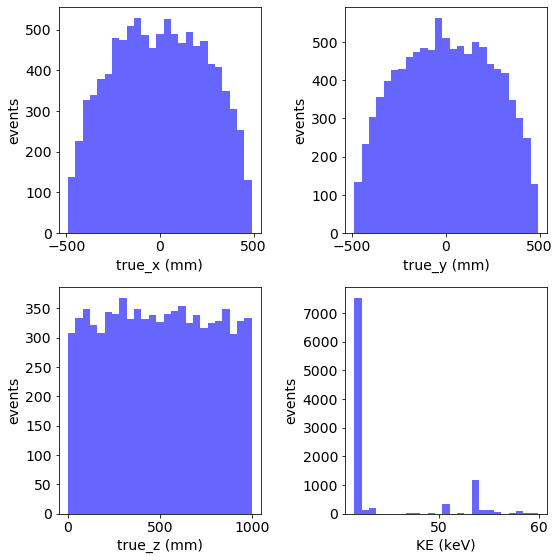

In [74]:
histos_df(krdst, 
          vars    = ('true_x','true_y','true_z','KE'), 
          varmins = [-500,-500,-500, 30], 
          varmaxs = [500,500,1000,60], 
          xlabels = ['true_x (mm)','true_y (mm)','true_z (mm)','KE (keV)'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [25],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (8,8))

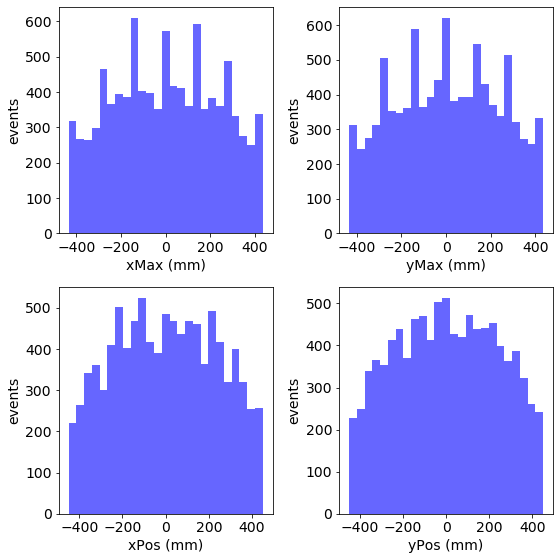

In [75]:
histos_df(krdst, 
          vars    = ('xMax','yMax','xPos','yPos'), 
          varmins = 4 * [-450], 
          varmaxs = 4 * [450], 
          xlabels = ['xMax (mm)','yMax (mm)','xPos (mm)','yPos (mm)'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [25],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (8,8))

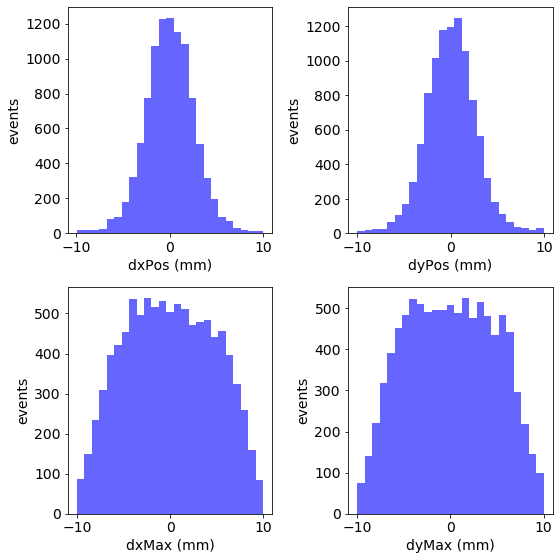

In [76]:
histos_df(krdst, 
          vars    = ('dxPos','dyPos','dxMax','dyMax'), 
          varmins = 4 * [-10], 
          varmaxs = 4 * [10], 
          xlabels = ['dxPos (mm)','dyPos (mm)','dxMax (mm)','dyMax (mm)'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [25],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (8,8))

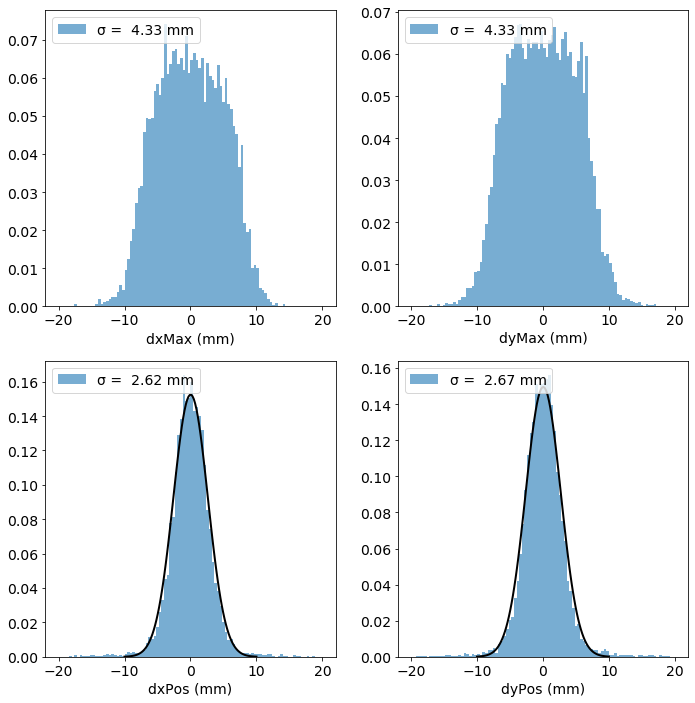

In [77]:
kr_point_resolution2(krdst, xlim=(-10,10), bins=100, figsize=(10,10))

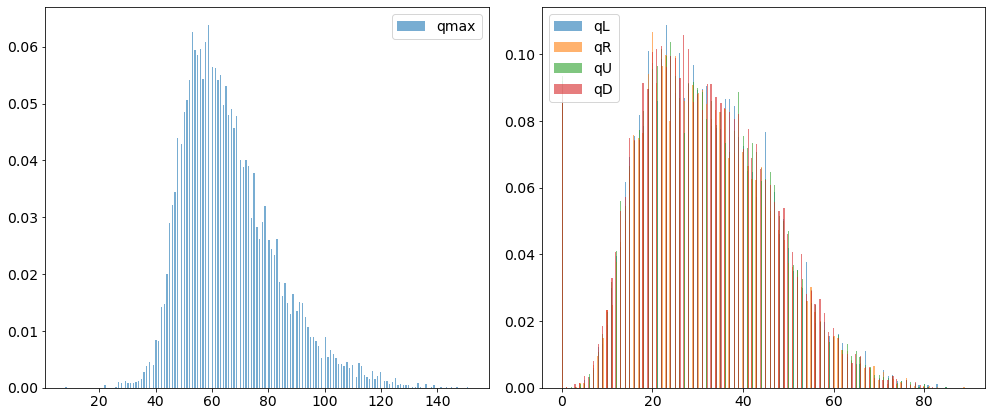

In [78]:
q_sipm(krdst,  bins=300, figsize=(14,6), alpha=0.6)

#### Summary:

- qMax peaks at 60 pes, while qL,qR,qR,qU,qD are about 30 pes, which is quite optimal for baricenter estimation. 
- Baricenter resolution is 2.6 mmm to be compared with digital resolution (4.3 mm).

### sipmPDE = 0.4

In [79]:
setup = Setup(sipmPDE    = 0.4,
              maskPDE    = 1.0,
              qTh        = 0.0,
              tpConfig   = "FLEX100_M6_O6")
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")

 dst name = /Users/jj/Development/flexdata/kdsts/PMTs_sipmPDE_0.4_maskPDE_1.0_qTh_0.0_FLEX100_M6_O6.csv


In [80]:
krdst = pd.read_csv(ofile)

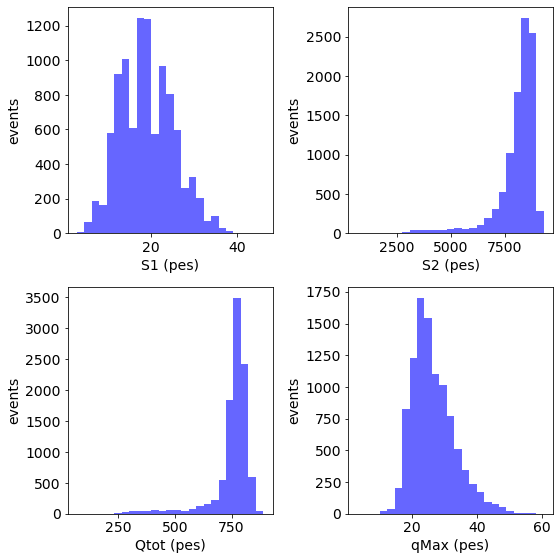

In [81]:
histos_df(krdst, 
          vars    = ('S1e','S2e','Qtot','qMax'), 
          varmins = [0,0,0, 0], 
          varmaxs = [50,10000,1000,200], 
          xlabels = ['S1 (pes)','S2 (pes)','Qtot (pes)','qMax (pes)'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [25],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (8,8))

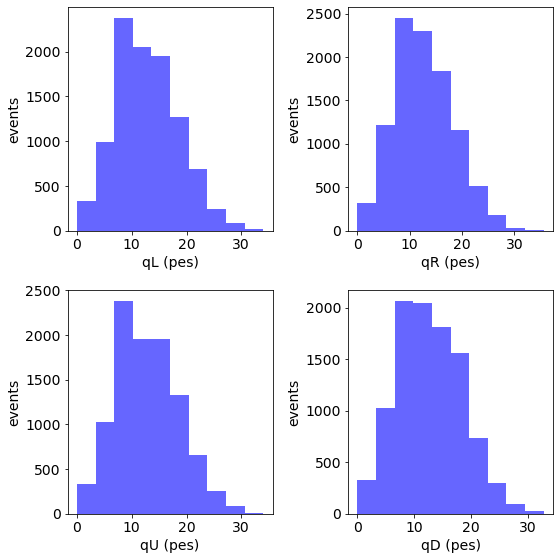

In [82]:
histos_df(krdst, 
          vars    = ('qL','qR','qU','qD'), 
          varmins = 4 * [0], 
          varmaxs = 4 * [100], 
          xlabels = ['qL (pes)','qR (pes)','qU (pes)','qD (pes)'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [10],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (8,8))

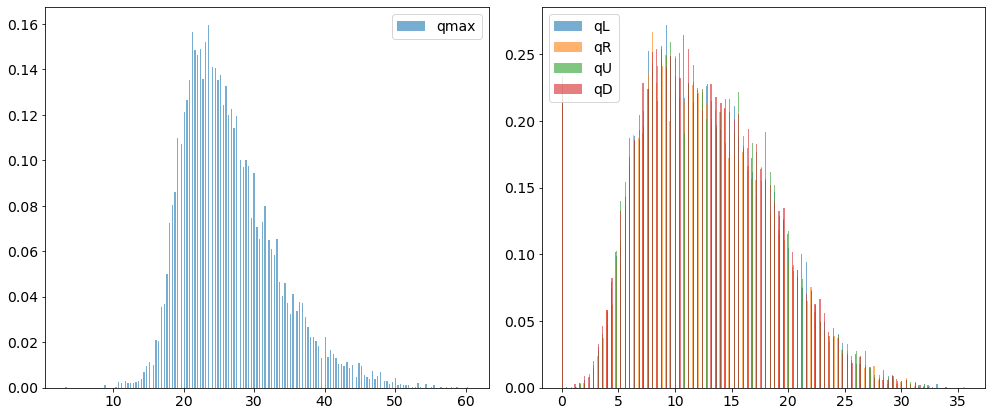

In [83]:
q_sipm(krdst,  bins=300, figsize=(14,6), alpha=0.6)

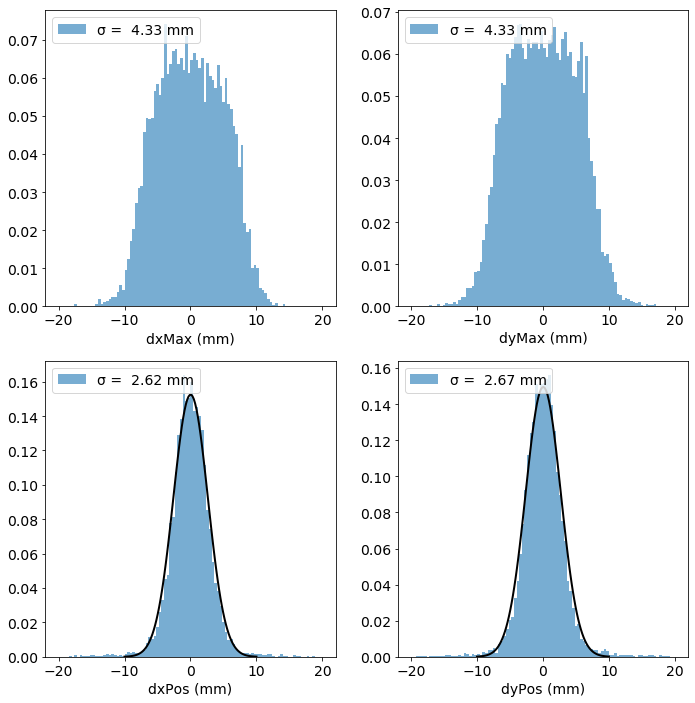

In [84]:
kr_point_resolution2(krdst, xlim=(-10,10), bins=100, figsize=(10,10))

### SiPM PDE = 0.4, Threshold = 5 pes 

In [85]:
setup = Setup(sipmPDE    = 0.4,
              maskPDE    = 1.0,
              qTh        = 5.0,
              tpConfig   = "FLEX100_M6_O6")
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")

 dst name = /Users/jj/Development/flexdata/kdsts/PMTs_sipmPDE_0.4_maskPDE_1.0_qTh_5.0_FLEX100_M6_O6.csv


In [86]:
krdst = pd.read_csv(ofile)

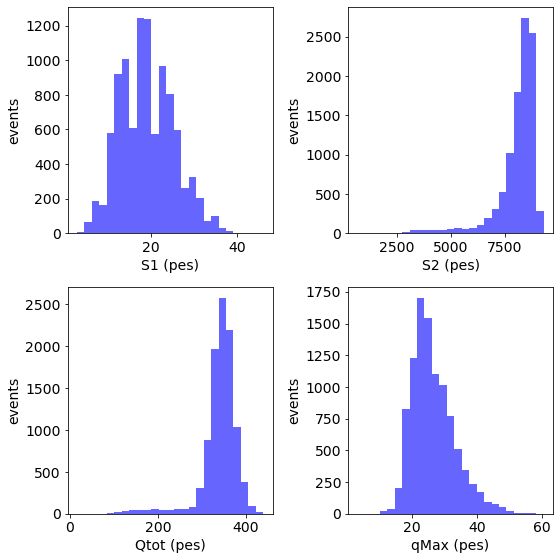

In [87]:
histos_df(krdst, 
          vars    = ('S1e','S2e','Qtot','qMax'), 
          varmins = [0,0,0, 0], 
          varmaxs = [50,10000,1000,200], 
          xlabels = ['S1 (pes)','S2 (pes)','Qtot (pes)','qMax (pes)'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [25],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (8,8))

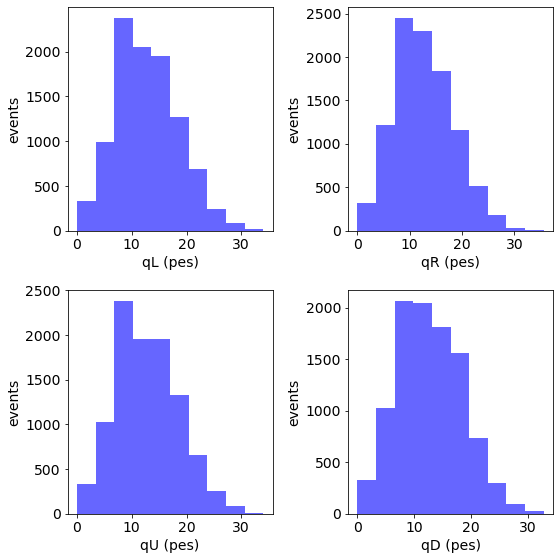

In [88]:
histos_df(krdst, 
          vars    = ('qL','qR','qU','qD'), 
          varmins = 4 * [0], 
          varmaxs = 4 * [100], 
          xlabels = ['qL (pes)','qR (pes)','qU (pes)','qD (pes)'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [10],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (8,8))

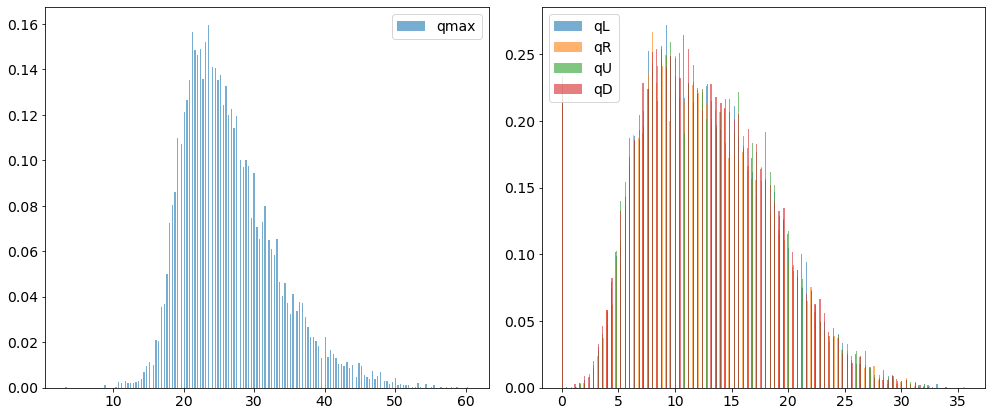

In [89]:
q_sipm(krdst,  bins=300, figsize=(14,6), alpha=0.6)

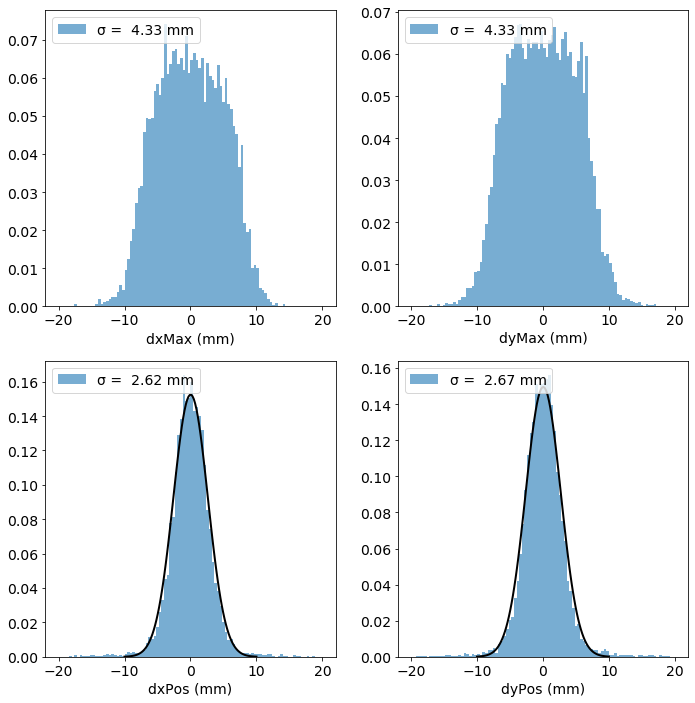

In [90]:
kr_point_resolution2(krdst, xlim=(-10,10), bins=100, figsize=(10,10))

### SiPM PDE = 0.4, Threshold = 5 pes, maskPDE = 0.4

In [91]:
setup = Setup(sipmPDE    = 0.4,
              maskPDE    = 0.4,
              qTh        = 5.0,
              tpConfig   = "FLEX100_M6_O6")
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")

 dst name = /Users/jj/Development/flexdata/kdsts/PMTs_sipmPDE_0.4_maskPDE_0.4_qTh_5.0_FLEX100_M6_O6.csv


In [92]:
krdst = pd.read_csv(ofile)

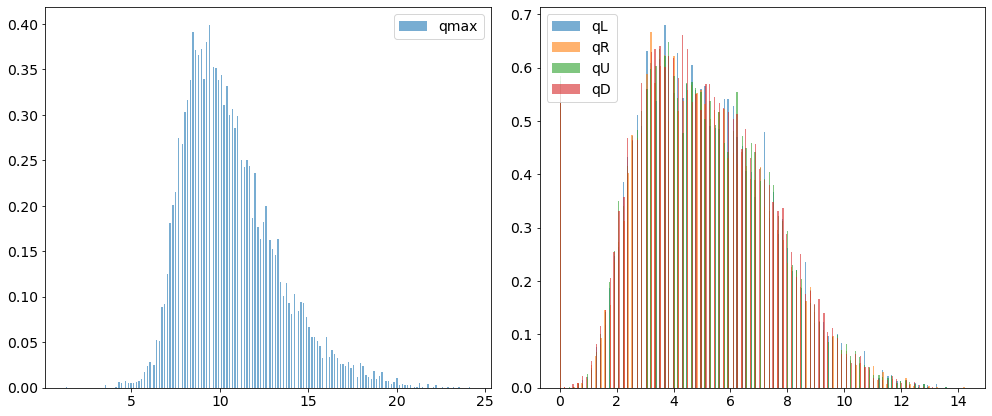

In [93]:
q_sipm(krdst,  bins=300, figsize=(14,6), alpha=0.6)

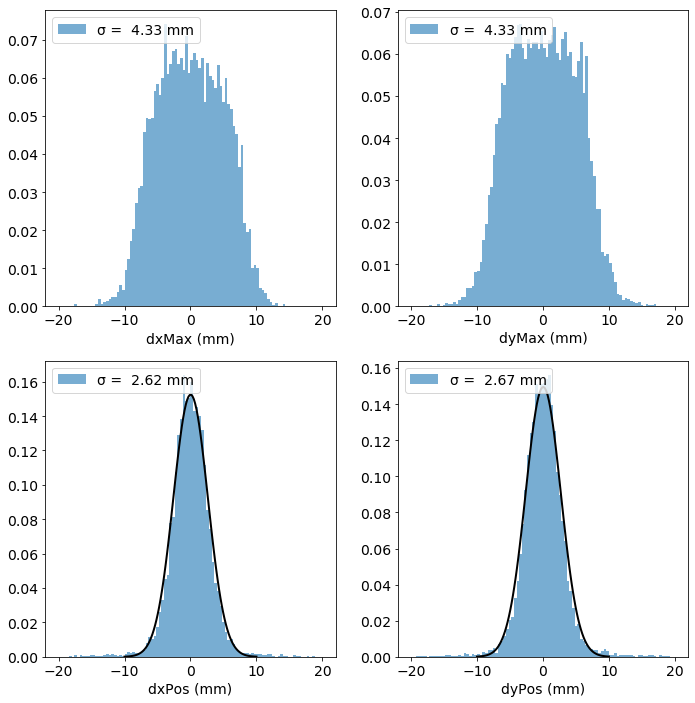

In [94]:
kr_point_resolution2(krdst, xlim=(-10,10), bins=100, figsize=(10,10))

## FLEX100_M6_O6_EL8bar configuration

- Increases the EL amplification according to 8 bar formula


In [95]:
setup = Setup(sipmPDE    = 0.4,
              maskPDE    = 0.4,
              qTh        = 5.0,
              tpConfig   = "FLEX100_M6_O6_EL8bar")
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")

 dst name = /Users/jj/Development/flexdata/kdsts/PMTs_sipmPDE_0.4_maskPDE_0.4_qTh_5.0_FLEX100_M6_O6_EL8bar.csv


In [96]:
krdst = pd.read_csv(ofile)

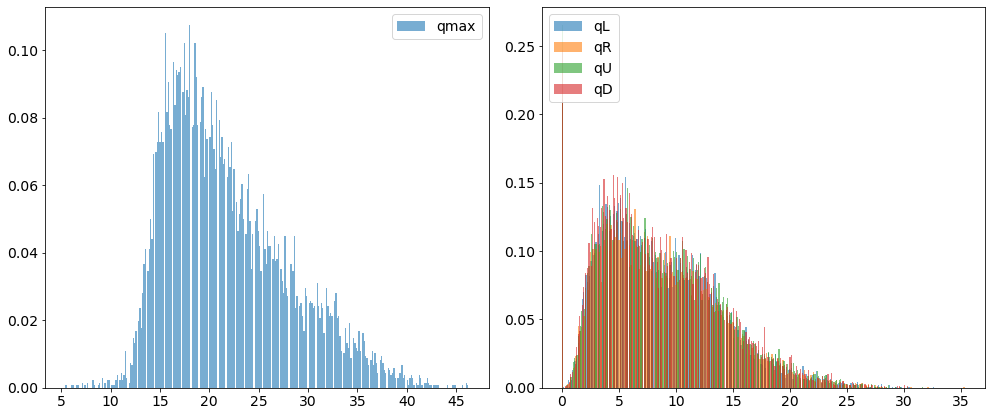

In [97]:
q_sipm(krdst,  bins=300, figsize=(14,6), alpha=0.6)

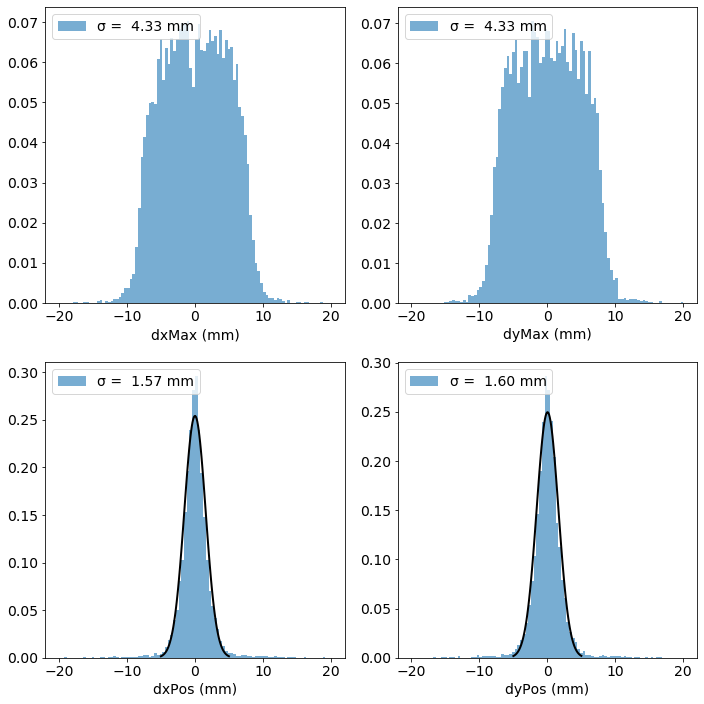

In [100]:
kr_point_resolution2(krdst, xlim=(-5,5), bins=100, figsize=(10,10))

#### NB: Resolution improves with EL and does not seem to depend very much of PDE and Masks

## FLEX100_M6_O6_EL8bar_memb

In [101]:
etup = Setup(sipmPDE    = 0.4,
              maskPDE    = 0.4,
              qTh        = 5.0,
              tpConfig   = "FLEX100_M6_O6_EL8bar_memb")
ofile_name = f"{setup.name}.csv"
ofile = f"{ofile_path}/{ofile_name}"
print(f" dst name = {ofile}")

 dst name = /Users/jj/Development/flexdata/kdsts/PMTs_sipmPDE_0.4_maskPDE_0.4_qTh_5.0_FLEX100_M6_O6_EL8bar.csv


In [102]:
krdst = pd.read_csv(ofile)

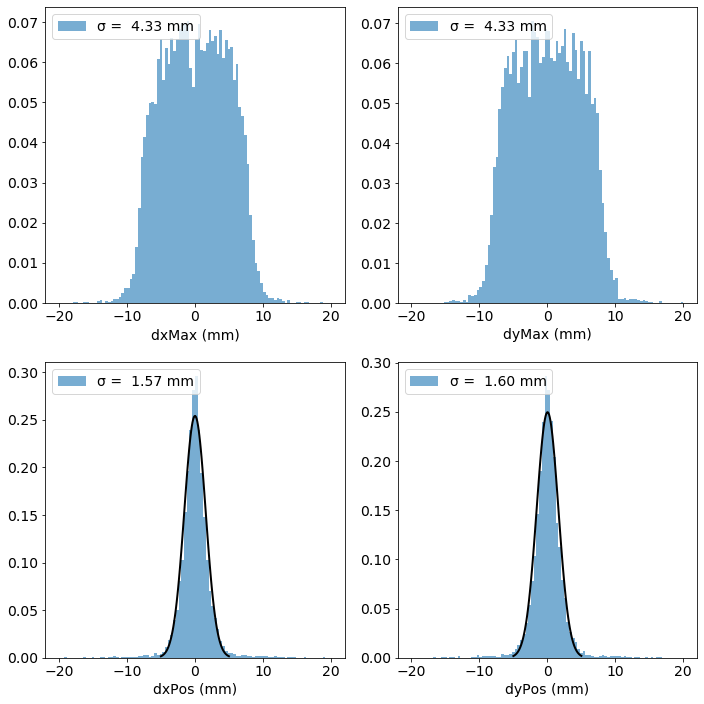

In [103]:
kr_point_resolution2(krdst, xlim=(-5,5), bins=100, figsize=(10,10))